# 📊 Dogecoin vs Federal Interest Rates Analysis

This notebook fetches and prepares data to analyze the relationship between Dogecoin price trends and U.S. Federal interest rates over the last 3 years.

## Goals:
- Download Dogecoin historical price data
- Download U.S. Federal Funds Effective Rate from FRED
- Merge and align data by date
- Perform initial exploratory visualizations

---

In [ ]:
# Install required packages (only run once per environment)
!pip install pandas yfinance matplotlib seaborn fredapi

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from fredapi import Fred

# Set plotting style
sns.set(style="whitegrid")

In [33]:
# Define date range (last 3 years)
end_date = datetime.today()
start_date = datetime(2020, 1, 1)

# Download Dogecoin data
doge = yf.download('DOGE-USD', start=start_date, end=end_date)
doge = doge[['Close']].rename(columns={"Close": "Dogecoin_Close"})
doge.head()

[*********************100%***********************]  1 of 1 completed


Price,Dogecoin_Close
Ticker,DOGE-USD
Date,
2020-01-01,0.002033
2020-01-02,0.002009
2020-01-03,0.002145
2020-01-04,0.002241
2020-01-05,0.002419


In [26]:
# Set your FRED API key here (create a free account at https://fred.stlouisfed.org/)
fred = Fred(api_key='6768b112bc2c95e9b76ffc5ce067a455')

# Download Federal Funds Rate data
fed_rate = fred.get_series('FEDFUNDS', observation_start=start_date, observation_end=end_date)
fed_rate = fed_rate.rename("Fed_Funds_Rate").to_frame()
fed_rate.index = pd.to_datetime(fed_rate.index)
fed_rate.head()

,Fed_Funds_Rate
2020-04-01,0.05
2020-05-01,0.05
2020-06-01,0.08
2020-07-01,0.09
2020-08-01,0.10


In [41]:
# Step 1: Reset Dogecoin index
doge_reset = doge.reset_index()

# Step 2: Flatten MultiIndex columns into single-level names
doge_reset.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in doge_reset.columns]

# Confirm fix
print("Dogecoin Columns after flattening:", doge_reset.columns)

# Step 3: Rename columns to standard
doge_reset.rename(columns={"Date_": "Date", "Close_DOGE-USD": "Dogecoin_Close"}, inplace=True)

# Step 4: Reset Fed rate and rename
fed_reset = fed_rate.reset_index()
fed_reset.columns = ['Date', 'Fed_Funds_Rate']

# Step 5: Merge both datasets
combined = pd.merge(doge_reset, fed_reset, on="Date", how="inner")
combined.dropna(inplace=True)

# Preview
combined.head()


Dogecoin Columns after flattening: Index(['Date_', 'Dogecoin_Close_DOGE-USD'], dtype='object')


,Date,Dogecoin_Close_DOGE-USD,Fed_Funds_Rate
0,2020-04-01,0.001867,0.05
1,2020-05-01,0.002494,0.05
2,2020-06-01,0.002647,0.08
3,2020-07-01,0.002354,0.09
4,2020-08-01,0.003689,0.10


In [42]:
# Merge Dogecoin and Fed rate data
# Reset index for both DataFrames
doge_reset = doge.reset_index()
fed_reset = fed_rate.reset_index()

# Flatten Dogecoin's MultiIndex column
doge_reset.columns = ['Date', 'Dogecoin_Close']

# Rename FRED columns
fed_reset.columns = ['Date', 'Fed_Funds_Rate']

# Merge using Date
combined = pd.merge(doge_reset, fed_reset, on="Date", how="inner")
combined.dropna(inplace=True)

# Preview the result
combined.head()


,Date,Dogecoin_Close,Fed_Funds_Rate
0,2020-04-01,0.001867,0.05
1,2020-05-01,0.002494,0.05
2,2020-06-01,0.002647,0.08
3,2020-07-01,0.002354,0.09
4,2020-08-01,0.003689,0.10


In [45]:
# Save raw Dogecoin data
doge_reset.to_csv("../data/dogecoin_data.csv", index=False)
print("✅ Saved: data/dogecoin_data.csv")

# Save raw Fed Funds Rate data
fed_reset.to_csv("../data/fed_funds_rate.csv", index=False)
print("✅ Saved: data/fed_funds_rate.csv")

# Save merged dataset
combined.to_csv("../data/combined_doge_fed.csv", index=False)
print("✅ Saved: data/combined_doge_fed.csv")



✅ Saved: data/dogecoin_data.csv
✅ Saved: data/fed_funds_rate.csv
✅ Saved: data/combined_doge_fed.csv


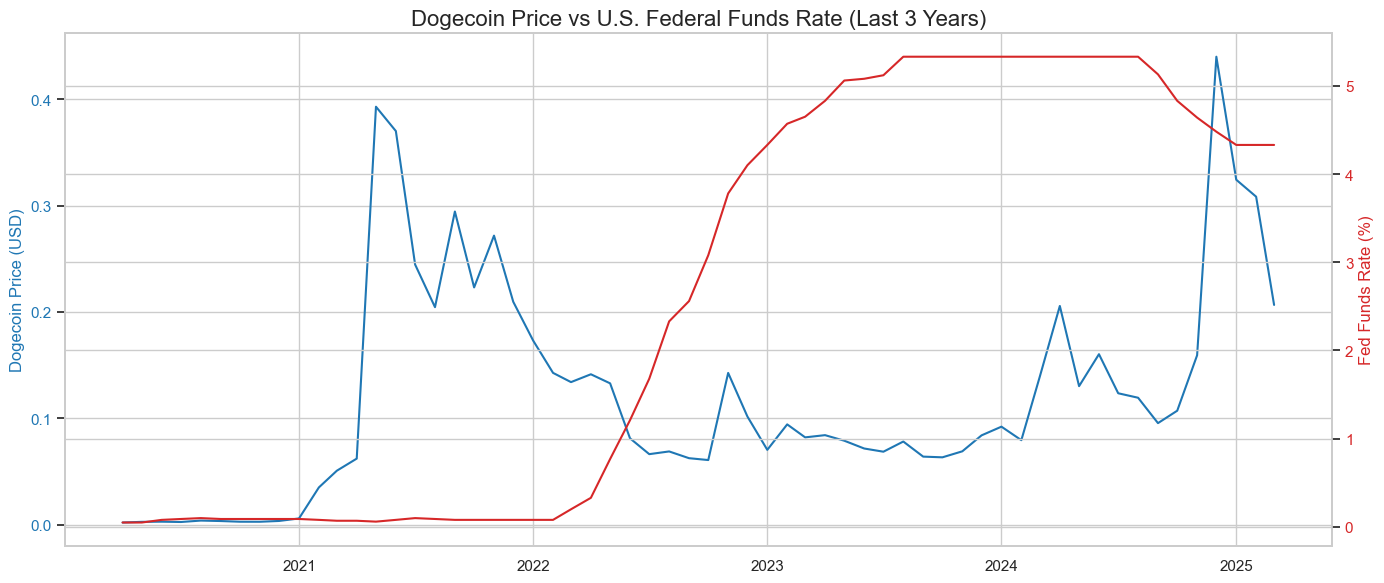

In [43]:
# 📈 Plot Dogecoin vs Fed Funds Rate (Dual Axis)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.title("Dogecoin Price vs U.S. Federal Funds Rate (Last 3 Years)", fontsize=16)

# Left Y-axis (Dogecoin Price)
ax1 = plt.gca()
ax1.plot(combined['Date'], combined['Dogecoin_Close'], color='tab:blue', label='Dogecoin Price')
ax1.set_ylabel('Dogecoin Price (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right Y-axis (Fed Funds Rate)
ax2 = ax1.twinx()
ax2.plot(combined['Date'], combined['Fed_Funds_Rate'], color='tab:red', label='Fed Funds Rate')
ax2.set_ylabel('Fed Funds Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Grid and legend
ax1.grid(True)
plt.tight_layout()
plt.show()


In [50]:
# Make sure 'Date' is datetime
combined['Date'] = pd.to_datetime(combined['Date'])

# Extract time-based features
combined['Year'] = combined['Date'].dt.year
combined['Month'] = combined['Date'].dt.month
combined['Month_Name'] = combined['Date'].dt.strftime('%B')

# Average Dogecoin price and interest rate per month
monthly_avg = combined.groupby(['Year', 'Month_Name']).agg({
    'Dogecoin_Close': 'mean',
    'Fed_Funds_Rate': 'mean'
}).reset_index()


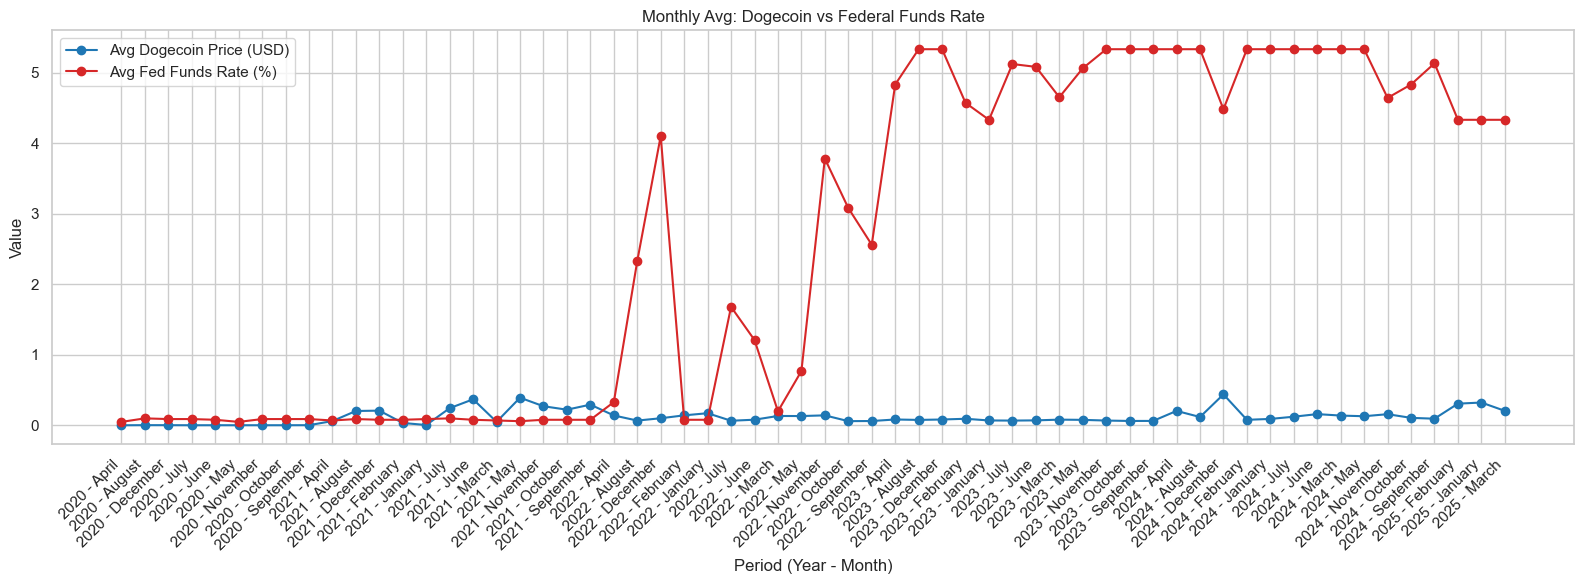

In [49]:
# Time Slicing
# Combine Year and Month into one label
monthly_avg['Period'] = monthly_avg['Year'].astype(str) + ' - ' + monthly_avg['Month_Name']

# Keep the periods in order
monthly_avg['Period'] = pd.Categorical(monthly_avg['Period'], 
                                       categories=monthly_avg['Period'].unique(), 
                                       ordered=True)

# Create line chart
plt.figure(figsize=(16, 6))
plt.plot(monthly_avg['Period'], monthly_avg['Dogecoin_Close'], marker='o', label='Avg Dogecoin Price (USD)', color='tab:blue')
plt.plot(monthly_avg['Period'], monthly_avg['Fed_Funds_Rate'], marker='o', label='Avg Fed Funds Rate (%)', color='tab:red')

plt.xticks(rotation=45, ha='right')
plt.title('Monthly Avg: Dogecoin vs Federal Funds Rate')
plt.xlabel('Period (Year - Month)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
#2. Percent Change

#See how much Dogecoin price changes month-to-month (MoM) or year-to-year (YoY).
# Sort by Year and Month to ensure order
monthly_avg_sorted = monthly_avg.sort_values(by=["Year", "Month_Name"])

# Calculate % change
monthly_avg_sorted['Dogecoin_Change_%'] = monthly_avg_sorted['Dogecoin_Close'].pct_change() * 100
monthly_avg_sorted['FedRate_Change_%'] = monthly_avg_sorted['Fed_Funds_Rate'].pct_change() * 100

# Round for readability
monthly_avg_sorted[['Dogecoin_Change_%', 'FedRate_Change_%']] = monthly_avg_sorted[['Dogecoin_Change_%', 'FedRate_Change_%']].round(2)

# Preview
monthly_avg_sorted[['Year', 'Month_Name', 'Dogecoin_Change_%', 'FedRate_Change_%']].head(10)
# Recreate Period column in sorted DataFrame
monthly_avg_sorted['Period'] = monthly_avg_sorted['Year'].astype(str) + ' - ' + monthly_avg_sorted['Month_Name']

# Show % change table for review
monthly_avg_sorted[['Year', 'Month_Name', 'Dogecoin_Change_%', 'FedRate_Change_%']].reset_index(drop=True).tail(24)




,Year,Month_Name,Dogecoin_Change_%,FedRate_Change_%
36,2023,February,12.30,-14.26
37,2023,January,-25.43,-5.25
38,2023,July,-2.49,18.24
39,2023,June,4.40,-0.78
40,2023,March,14.65,-8.46
41,2023,May,-3.84,8.82
42,2023,November,-12.66,5.34
43,2023,October,-8.20,0.00
44,2023,September,1.04,0.00
45,2024,April,221.96,0.00


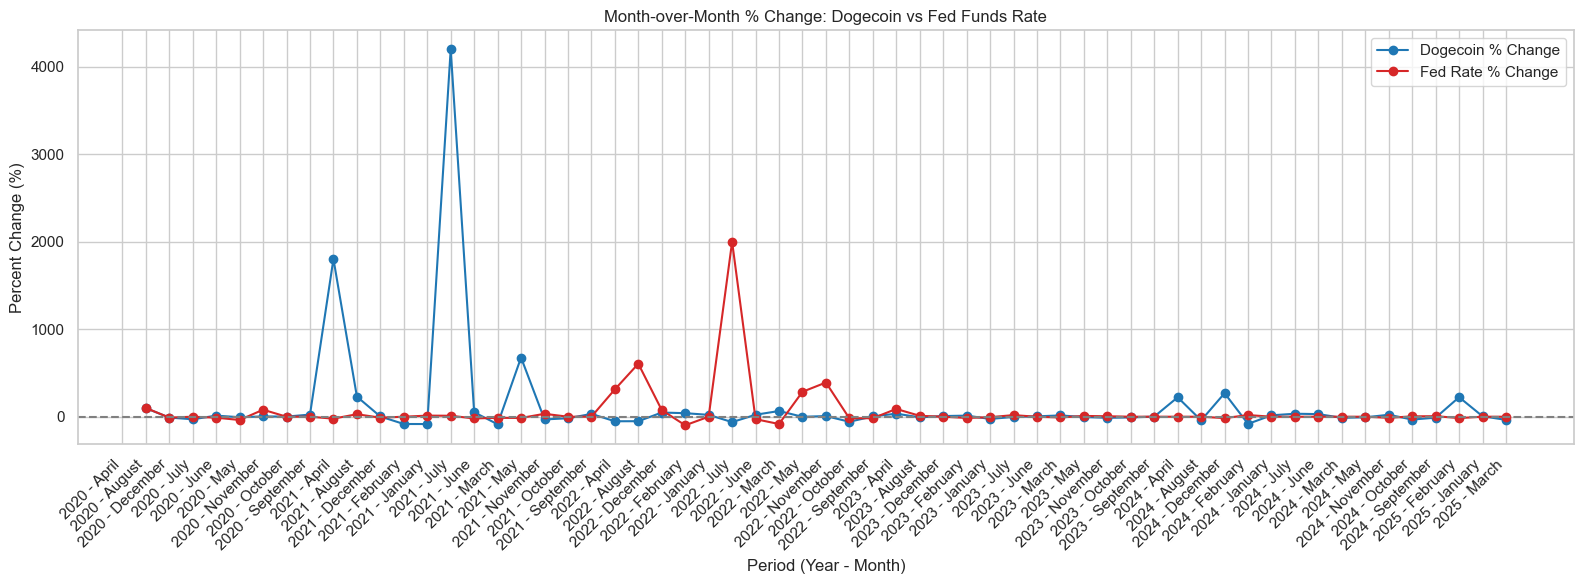

In [55]:
# Optional: force correct order for plotting
monthly_avg_sorted['Period'] = pd.Categorical(monthly_avg_sorted['Period'], 
                                              categories=monthly_avg_sorted['Period'].unique(), 
                                              ordered=True)

# Visualization % Change 
plt.figure(figsize=(16, 6))
plt.plot(monthly_avg_sorted['Period'], monthly_avg_sorted['Dogecoin_Change_%'], label='Dogecoin % Change', marker='o', color='tab:blue')
plt.plot(monthly_avg_sorted['Period'], monthly_avg_sorted['FedRate_Change_%'], label='Fed Rate % Change', marker='o', color='tab:red')

plt.axhline(0, linestyle='--', color='gray')
plt.xticks(rotation=45, ha='right')
plt.title('Month-over-Month % Change: Dogecoin vs Fed Funds Rate')
plt.xlabel('Period (Year - Month)')
plt.ylabel('Percent Change (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# Rolling 30-Day Volatility of Dogecoin
# Make sure Date is datetime
combined['Date'] = pd.to_datetime(combined['Date'])

# Sort the combined dataset by Date
combined = combined.sort_values('Date')

# Calculate daily % change in Dogecoin price
combined['Daily_Return'] = combined['Dogecoin_Close'].pct_change()

# Calculate 30-day rolling standard deviation (volatility)
combined['Volatility_30d'] = combined['Daily_Return'].rolling(window=30).std()

# Show preview
combined[['Date', 'Dogecoin_Close', 'Daily_Return', 'Volatility_30d']].tail(10)


,Date,Dogecoin_Close,Daily_Return,Volatility_30d
50,2024-06-01,0.160200,0.231039,0.347907
51,2024-07-01,0.123442,-0.229451,0.349198
52,2024-08-01,0.119236,-0.034073,0.347236
53,2024-09-01,0.095354,-0.200292,0.349521
54,2024-10-01,0.107043,0.122585,0.349887
55,2024-11-01,0.159185,0.487113,0.358903
56,2024-12-01,0.440023,1.764224,0.466551
57,2025-01-01,0.324306,-0.262979,0.468583
58,2025-02-01,0.308357,-0.049179,0.469397
59,2025-03-01,0.206537,-0.330202,0.475071


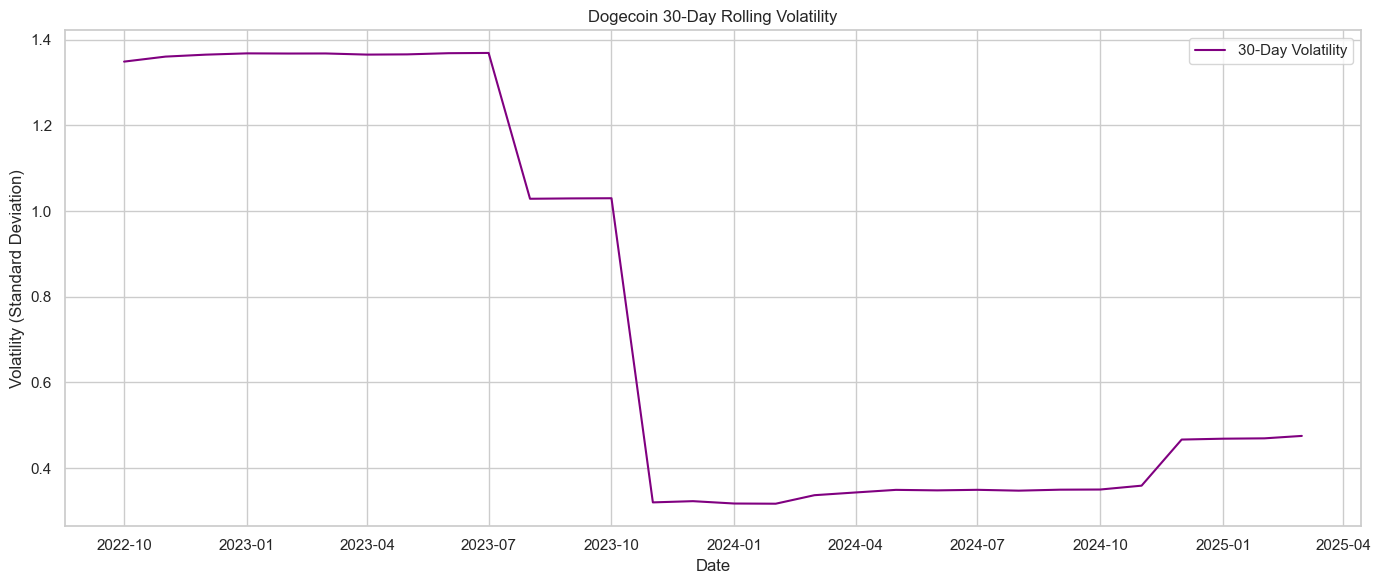

In [61]:
plt.figure(figsize=(14, 6))
plt.plot(combined['Date'], combined['Volatility_30d'], color='purple', label='30-Day Volatility')
plt.title('Dogecoin 30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
# Prepare export-ready DataFrame
percent_change_df = monthly_avg_sorted[['Year', 'Month_Name', 'Dogecoin_Change_%', 'FedRate_Change_%']].copy()

# Save to the main /data folder
percent_change_df.to_csv("../data/percent_change_monthly.csv", index=False)

print("✅ percent_change_monthly.csv saved to data/")


✅ percent_change_monthly.csv saved to data/


In [63]:
# Ensure Date is datetime and sorted
combined['Date'] = pd.to_datetime(combined['Date'])
combined = combined.sort_values('Date')

# Extract Year and Month
combined['Year'] = combined['Date'].dt.year
combined['Month'] = combined['Date'].dt.month
combined['Month_Name'] = combined['Date'].dt.strftime('%B')

# Group by Year and Month, then calculate average volatility
monthly_volatility = combined.groupby(['Year', 'Month_Name']).agg({
    'Volatility_30d': 'mean'
}).reset_index()

# Round for readability
monthly_volatility['Volatility_30d'] = monthly_volatility['Volatility_30d'].round(5)

# Save to CSV in /data folder
monthly_volatility.to_csv("../data/monthly_volatility_summary.csv", index=False)

print("✅ monthly_volatility_summary.csv saved to /data/")


✅ monthly_volatility_summary.csv saved to /data/


In [64]:
# ✅ Step 1: Prepare each individual table
monthly_avg_part = monthly_avg_sorted[['Year', 'Month_Name', 'Dogecoin_Close', 'Fed_Funds_Rate']].copy()
percent_change_part = monthly_avg_sorted[['Dogecoin_Change_%', 'FedRate_Change_%']].copy()
volatility_part = monthly_volatility[['Volatility_30d']].copy()

# ✅ Step 2: Merge them column-wise (same row order)
master_table = pd.concat([monthly_avg_part, percent_change_part, volatility_part], axis=1)

# ✅ Step 3: Create a clean Period column
master_table['Period'] = master_table['Year'].astype(str) + ' - ' + master_table['Month_Name']
master_table = master_table[['Period'] + [col for col in master_table.columns if col != 'Period']]

# ✅ Step 4: Save to CSV
master_table.to_csv("../data/master_monthly_summary.csv", index=False)

print("✅ master_monthly_summary.csv saved to /data/")


✅ master_monthly_summary.csv saved to /data/
